__Import libraries and packages for analysis and extracting data, import Tensorflow framework and Keras API with neccessary layers for NLP task.__

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import nltk
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import TextVectorization, Embedding, Bidirectional, GRU, Dense, Dropout
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report

2023-12-10 18:03:53.857054: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-10 18:03:53.890562: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 18:03:53.890596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 18:03:53.890615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 18:03:53.897073: I tensorflow/core/platform/cpu_feature_g

In [3]:
warnings.filterwarnings('ignore')
np.set_printoptions(suppress = True)
nltk.download('punkt')
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package punkt to /home/armh12/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/armh12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Extract data from CSV file.

Look at EDA part in analysis notebook.

In [4]:
data = pd.read_csv('BA_AirlineReviews.csv')
data.head(2)

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0


In [5]:
# extract text columns and target column
X = data[['ReviewBody']]
y = data[['Recommended']]
# 0 for no, 1 for yes
y = pd.get_dummies(y, dtype = int, drop_first = True).rename(columns = {'Recommended_yes':'Recommended'})

In [6]:
# first we need to remove stop words by using NLTK
def stop_words_rm(text: str):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X['TokenizedText'] = X['ReviewBody'].apply(stop_words_rm)
display(X.head(2))

,ReviewBody,TokenizedText
0,4 Hours before takeoff we received a Mail stat...,hours takeoff received mail stating cryptic me...
1,I recently had a delay on British Airways from...,recently delay british airways bru lhr due sta...


In [30]:
# split data to train-test splits, validation will be set in model
X_train, X_test, y_train, y_test = train_test_split(X['TokenizedText'], y, random_state = 42, test_size = 0.2)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (2960,)
X_test shape: (741,)
y_train shape: (2960, 1)
y_test shape: (741, 1)


In [31]:
# define text vectorization layer
max_features = 3000
sequence_length = 100
vectorizer = TextVectorization(max_tokens = max_features, output_sequence_length = sequence_length)
vectorizer.adapt(X.TokenizedText)
# define function for mapping
def vectorize_text(text):
    return vectorizer(text)
# mapping with vectorizing function
X_train = X_train.map(vectorize_text)
X_test = X_test.map(vectorize_text)
# converting to numpy arrays
# train
np_X_train = []
for elem in X_train:
    np_X_train.append(np.array(elem))
np_X_train = np.array(np_X_train)
# test
np_X_test = []
for elem in X_test:
    np_X_test.append(np.array(elem))
np_X_test = np.array(np_X_test)

In [32]:
# making y-s as one-hot encoded vectors
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [33]:
# build the model
model = Sequential([
    Embedding(input_dim = max_features, output_dim = 50, name = 'Embeddings'),
    Bidirectional(GRU(32, kernel_regularizer = keras.regularizers.l2(0.01))),
    Dense(64, activation = 'relu'),
    Dropout(0.2),
    Dense(2, activation = 'sigmoid')
])

model.compile(optimizer = 'adam',
              loss = keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

history = model.fit(np_X_train, y_train_hot, validation_split = 0.1, epochs = 100, verbose = 0)

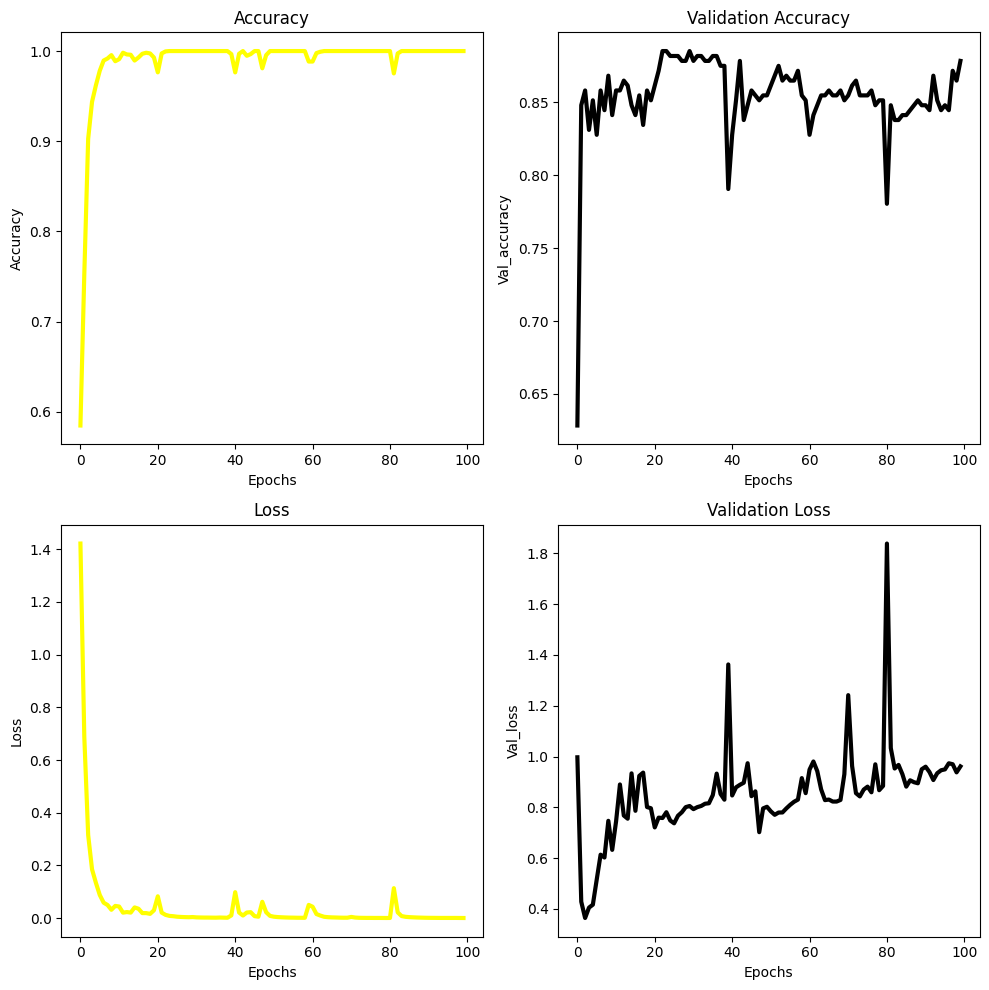

In [34]:
# models history
plot_topics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
plot_titles = ['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss']
colors = ['yellow', 'black']
plt.figure(figsize = (10,10))
for i, topic in enumerate(plot_topics):
    plt.subplot(2,2,i + 1)
    sns.lineplot(history.history[plot_topics[i]], color = colors[i % 2], lw = 3)
    plt.title(plot_titles[i])
    plt.xlabel('Epochs')
    plt.ylabel(plot_topics[i].capitalize())
plt.tight_layout()
plt.show();

In [35]:
# make predictions
model.evaluate(np_X_test, y_test_hot)
predictions = model.predict(np_X_test)
y_pred = [np.argmax(elem) for elem in predictions]

24/24 [==============================] - 1s 10ms/step


              precision    recall  f1-score   support

          No       0.84      0.89      0.87       446
         Yes       0.82      0.74      0.78       295

    accuracy                           0.83       741
   macro avg       0.83      0.82      0.82       741
weighted avg       0.83      0.83      0.83       741



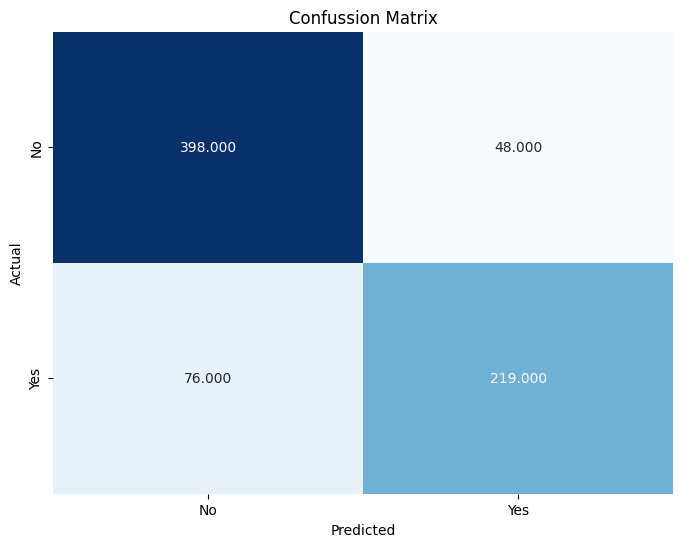

In [52]:
# evaluation of model
print(classification_report(y_test, y_pred, target_names = ['No', 'Yes']))
plt.figure(figsize = (8,6))
conf_matrix = sns.heatmap(data = confusion_matrix(y_test, y_pred), cbar = False, annot = True, fmt = '.3f', cmap = 'Blues')
conf_matrix.set_xticklabels(['No', 'Yes'])
conf_matrix.set_yticklabels(['No', 'Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confussion Matrix')
plt.show();